In [1]:
%matplotlib inline

import os
import yaml

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from scipy.spatial import cKDTree

import astropy.io.fits as pyfits
from astropy.utils.data import download_file
from astropy.cosmology import WMAP9
import astropy.units as u
from astropy.io import fits

import grizli
import grizli.catalog
from grizli import utils

import eazy
import msaexp
import msaexp.spectrum
import eazy.utils
import msaexp.resample
from astroquery.sdss import SDSS
from astropy import coordinates as coords


In [4]:
! pip install git+https://github.com/karllark/dust_attenuation.git

python(32532) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Cloning https://github.com/karllark/dust_attenuation.git to /private/var/folders/74/__d4fvn923b5nsfrydw7vf4m0000gn/T/pip-req-build-2mju72pv
  Running command git clone --filter=blob:none --quiet https://github.com/karllark/dust_attenuation.git /private/var/folders/74/__d4fvn923b5nsfrydw7vf4m0000gn/T/pip-req-build-2mju72pv
  Resolved https://github.com/karllark/dust_attenuation.git to commit 02a1067a555562adb5ec74766d0569f6eb9de87d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
from SDSS_stacking import SDSS_stacker

# Loading Resolution

In [5]:
import astropy
c=astropy.constants.c.to('km/s')

In [6]:
R_prism = fits.open('jwst_nirspec_prism_disp.fits')[1].data
def Resolution(L):
    return np.interp(L, R_prism['wavelength']*10**4, R_prism['R'])

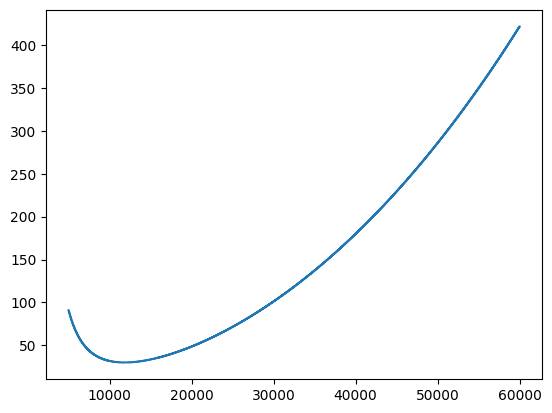

In [7]:
plt.step(R_prism['wavelength']*10**4, R_prism['R'], where='mid', label='NIRSpec Prism')

# Read the Table from DJA of Emission lines

In [8]:
# Load the complete table
table_url = "https://s3.amazonaws.com/msaexp-nirspec/extractions/dja_msaexp_emission_lines_v4.0.csv.gz"
tab = utils.read_catalog(download_file(table_url, cache=True), format='csv')

In [9]:
# Column descriptions
columns_url = "https://s3.amazonaws.com/msaexp-nirspec/extractions/dja_msaexp_emission_lines_v4.0.columns.csv"
tab_columns = utils.read_catalog(download_file(columns_url, cache=True), format='csv')

# Set column metadata
for row in tab_columns:
    c = row['column']
    if row['unit'] != '--':
        tab[c].unit = row['unit']
    if row['format'] != '--':
        tab[c].format = row['format']
    if row['description'] != '--':
        tab[c].description = row['description']

tab.info()

<GTable length=52181>
        name         dtype   unit  format                                       description                                           class     n_bad
------------------- ------- ------ ------ ---------------------------------------------------------------------------------------- ------------ -----
               file   str57                                                                                           DJA filename       Column     0
              srcid   int64                                                                                Source ID from APT plan       Column     0
                 ra float64    deg    .8f                                                                         RA from APT plan       Column     0
                dec float64    deg    .8f                                                                        Dec from APT plan       Column     0
            grating    str5                                                   

# All MSAexp PRISM spectra in a single table

In [8]:
combined_spectra_file = "dja_msaexp_emission_lines_v4.0.prism_spectra.fits"

if os.path.exists(combined_spectra_file):
    prism_spectra = utils.read_catalog(combined_spectra_file)
else:
    # Combined prism spectra in a single big table (595 Mb)
    prism_spectra = utils.read_catalog(
        download_file(
            f"https://s3.amazonaws.com/msaexp-nirspec/extractions/{combined_spectra_file}",
            cache=True
        ),
        format='fits',
    )


# Load the complete table
table_url = "https://s3.amazonaws.com/msaexp-nirspec/extractions/dja_msaexp_emission_lines_v4.0.csv.gz"
tab = utils.read_catalog(download_file(table_url, cache=True), format='csv')
# Column descriptions
columns_url = "https://s3.amazonaws.com/msaexp-nirspec/extractions/dja_msaexp_emission_lines_v4.0.columns.csv"
tab_columns = utils.read_catalog(download_file(columns_url, cache=True), format='csv')

# Set column metadata
for row in tab_columns:
    c = row['column']
    if row['unit'] != '--':
        tab[c].unit = row['unit']
    if row['format'] != '--':
        tab[c].format = row['format']
    if row['description'] != '--':
        tab[c].description = row['description']
        

# Reading the spectrum

In [10]:
#setton
spec_file=["macsj0647-v4_prism-clear_1433_1045.spec.fits",
              'jades-gdn-v4_prism-clear_1181_68797.spec.fits',
              'rubies-uds1-v4_prism-clear_4233_40579.spec.fits',
              'jades-gds-w03-v4_prism-clear_1212_537.spec.fits',
              'jades-gdn2-v4_prism-clear_1181_28074.spec.fits',
              'uncover-v4_prism-clear_2561_4286.spec.fits',
              'cosmos-transients-v4_prism-clear_6585_58018.spec.fits',
              'gds-deep-v4_prism-clear_1210_13704.spec.fits',
              'uncover-62-v4_prism-clear_2561_58453.spec.fits',
              'gds-barrufet-s67-v4_prism-clear_2198_4820.spec.fits',
              "rubies-uds3-v4_prism-clear_4233_47509.spec.fits",

              'ceers-ddt-v4_prism-clear_2750_1768.spec.fits',
              'jades-gdn-v4_prism-clear_1181_53501.spec.fits',
              'rubies-uds1-v4_prism-clear_4233_31747.spec.fits',
              'uncover-v4_prism-clear_2561_38108.spec.fits',
              'jades-gds-wide-v4_prism-clear_1180_13329.spec.fits',
              'jades-gdn09-v4_prism-clear_1181_73488.spec.fits',
              'jades-gds-wide-v4_prism-clear_1180_12402.spec.fits',
              'jades-gdn-v4_prism-clear_1181_38147.spec.fits',
              'jades-gdn10-v4_prism-clear_1181_27830.spec.fits']


FITS_URL = "https://s3.amazonaws.com/msaexp-nirspec/extractions/{root}/{file}"
is_prism = tab['grating'] == 'PRISM'
has_z_spec = tab['z_best'] >= 0
good_grade = tab['grade'] >= 3

prism_z = is_prism & has_z_spec & good_grade
LRD_MSAID = np.isin(tab[prism_z]['file'],spec_file)
row = tab[prism_z][LRD_MSAID]

def get_spectrum_from_dja(row):
    spec = msaexp.spectrum.SpectrumSampler(FITS_URL.format(**row))
    return spec

In [28]:
get_spectrum_from_dja(row[0]).spec

wave,flux,err,sky,path_corr,npix,flux_sum,profile_sum,var_sum,corr,escale,full_err,valid,R,to_flam
,,,uJy,,,,,,,,uJy,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64
0.54,0.0,0.0,--,--,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False,78.12679808305622,102.80948491083677
0.5429924907410937,0.0,0.0,--,--,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False,77.29061324613852,101.679418941688
0.5460340296489751,0.0,0.0,--,--,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False,76.4599228511855,100.54981689842369
0.549125977329285,-0.1268426689786694,0.1976558412226323,-0.01798100662213053,1.0931173131805287,4.0,-0.14667353109020073,1.3195704294102915,0.08851616018479186,1.0,1.0,0.1976558412226323,True,75.62513330053197,99.42067891248819
0.5522694495525959,0.10026951973517978,0.08545422767685641,-0.036341466931908144,1.0946953384444629,14.0,0.3523708275240113,1.9576688611080901,0.0902187410483834,1.0,1.0,0.08547775510905269,True,74.80148474265083,98.29211130367247
0.5554660585535945,-0.013359644671356526,0.05687767200999321,0.010763984793388474,1.092523220157031,16.0,0.07986511396087873,2.8063039531397904,0.18393685766294351,1.0,1.0,0.05687767200999321,True,73.97139238182147,97.16405908159989
0.5587169324053721,-0.051067781985183365,0.050789229790658724,0.024942421107761518,1.0945391356783067,16.0,-0.2999058621877928,2.80435613538366,0.05129829698334365,1.0,1.0,0.050789229790658724,True,73.1512721080452,96.03665753961846
0.5620237452009996,0.1100466022423328,0.05074143250043843,-0.021786867711038257,1.0941068276106076,14.0,0.2871622180246897,2.4529621400052997,0.04162346668989923,1.0,1.0,0.050789143269625865,True,72.32969006401488,94.90986892100776


In [21]:
#rusakov
MSA_ID = np.array([68797,73488,42046,49140,1244,53501,51623, 58237, 38147,50052, 60935])
spec_file=['jades-gdn-v4_prism-clear_1181_68797.spec.fits',
           'jades-gdn09-v4_prism-clear_1181_73488.spec.fits',
           'rubies-egs53-v4_prism-clear_4233_42046.spec.fits',
           'rubies-egs63-v4_prism-clear_4233_49140.spec.fits',
           'ceers-v4_prism-clear_1345_1244.spec.fits',
           'jades-gdn-v4_prism-clear_1181_53501.spec.fits',
           'egs-nelsonx-v4_prism-clear_4106_51623.spec.fits',
           'rubies-egs62-v4_prism-clear_4233_58237.spec.fits',
           'jades-gdn-v4_prism-clear_1181_38147.spec.fits',
           'rubies-egs53-v4_prism-clear_4233_50052.spec.fits',
           'rubies-egs61-v4_prism-clear_4233_60935.spec.fits']

FITS_URL = "https://s3.amazonaws.com/msaexp-nirspec/extractions/{root}/{file}"
is_prism = tab['grating'] == 'PRISM'
has_z_spec = tab['z_best'] >= 0
good_grade = tab['grade'] >= 3

prism_z = is_prism & has_z_spec & good_grade
LRD_MSAID = np.isin(tab[prism_z]['file'],spec_file)
row = tab[prism_z][LRD_MSAID]

def get_spectrum_from_dja(row):
    spec = msaexp.spectrum.SpectrumSampler(FITS_URL.format(**row))
    return spec
LRD_MSAID = np.isin(tab[prism_z]['srcid'],MSA_ID)

In [ ]:
lam=[]
flux=[]
flux_err=[]
z_spec=[]
template=[]

In [13]:
hbeta_eq_lrd=[]
for r in tab[prism_z][LRD_MSAID]:

    hbeta_eq_lrd.append(r['eqw_hb'])

FOr the NLSY1

In [22]:
for row in tab[prism_z][LRD_MSAID]:
	print(row['srcid'])

1244
51623
73488
38147
53501
68797
42046
50052
60935
58237
49140


In [ ]:
from SDSS_stacking import SDSS_stacker

In [24]:
fits.open("seyfert-catalog-v1.fits", memmap=True, lazy_load_hdus=True)[1].data

FITS_rec([('000000.47-002703.9', 'spec-4216-55477-0310', 1.978307e-03, -0.4510883, 0.25     , -19.36213,  194.6679,    5.422921,  -14.43661,  7.303339e-03, 1788.984,   40.21278,   41.93917,  7.303339e-03,   14.25702 ,  51.82722,  3.95454 , -14.94622, 0.02633337, 2123.364, 178.2669 , 41.42955, 0.02633337,  4.760979,   16.2591 ,    1.223476,  -15.53974,  2.523824e-02,  226.4511,    8.889929,   40.83604,  2.523824e-02,   12.65212 ,  4.680401 , 0.7990089, -16.06235, 0.0608534 , 257.1082,  5.913889, 40.31343, 0.0608534 , 4.353984 , 10.40258 , 0.2973907, -15.62238, 0.01210865, 258.1309,  5.733705, 40.7534 , 0.01210865, 11.66205 , 32.59556 ,  0.9004431, -15.14407, 0.0121142 , 265.4583,  5.273992, 41.23171, 0.0121142 , 33.72964 ,    2.574738,  1.909852e-01,  -16.31874,  2.981714e-02,  227.1618,    8.959289,   40.05703,  2.981714e-02,  2.091801e+00,    7.30842 ,  5.072257e-01,  -15.84942,  2.981928e-02,  234.88  ,   10.2768 ,   40.52636,  2.981928e-02,    5.896177,    3.153131,  7.487832e-01,  

Re‑binning SDSS spectra:   0%|          | 0/4925 [00:00<?, ?it/s]

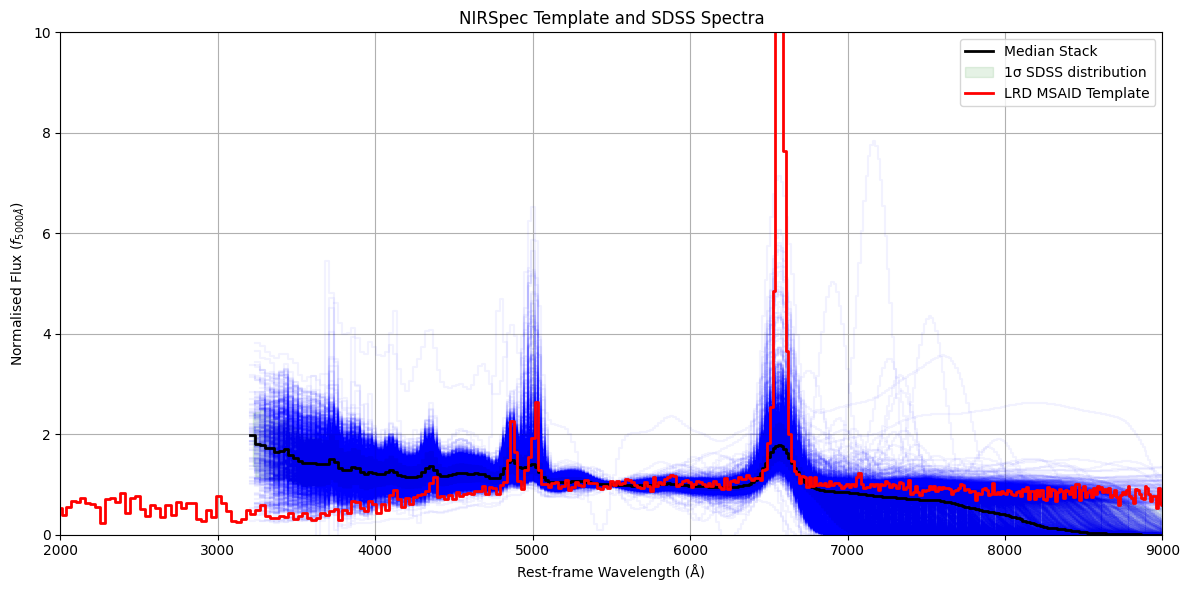

In [51]:
#!/usr/bin/env python3
"""sdss_stacker_full.py

End‑to‑end workflow to:

1. Read an SDSS catalogue & individual SDSS spectra.
2. Read a NIRSpec reference spectrum + its resolving power curve R(λ).
3. Shift, convolve to NIRSpec resolution, and re‑sample each SDSS spectrum onto the
   common NIRSpec *rest‑frame* wavelength grid.
4. Continuum‑normalise each SDSS spectrum over a user window.
5. Propagate 1σ uncertainties through all of the above.
6. Provide fast **Gaussian bootstrapping** utilities that operate *after* alignment
   so you can generate noisy realisations either of the full spectral matrix or of
   the *stacked* spectrum.

Array orientation used throughout
---------------------------------
We store aligned spectra in shape **(N_pix, N_spec)** — i.e. rows are wavelength
pixels on the common grid; columns are distinct SDSS objects.  This orientation is
optimal for vectorised bootstrapping because wavelength is contiguous in memory.

If you previously relied on the opposite ordering, transpose at I/O boundaries.

Key public methods
------------------
- ``aligning_SDSS_to_NIRSpec(sig=True)``  → build ``rebinned_spectra`` (+ ``rebinned_sigma``).
- ``Stack(sig=True)``                     → robust percentiles across *observed* spectra.
- ``bootstrap_spectra(n_boot=1000)``      → noisy matrix (N_pix, N_spec*n_boot).
- ``bootstrap_stack(n_boot=1000)``        → distribution of the *stacked* spectrum.

"""

from __future__ import annotations

import glob
from typing import Callable, Iterable, Sequence

import numpy as np
import astropy.io.fits as fits
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.auto import tqdm
import msaexp  # external dependency
import matplotlib.pyplot as plt

try:  # optional; numba speeds up the per‑pixel convolution if installed
    from numba import njit
except Exception:  # pragma: no cover - fallback when numba missing
    def njit(*args, **kwargs):  # type: ignore
        def decorator(f):
            return f
        return decorator


# ------------------------------------------------------------------
# Low‑level instrumental convolution + resampling
# ------------------------------------------------------------------
@njit(cache=True)
def _resample_template_instr_numba(
    spec_wobs: np.ndarray,
    spec_R_fwhm: np.ndarray,
    templ_wobs: np.ndarray,
    templ_flux: np.ndarray,
    templ_unc: np.ndarray | None,
    wave_min: float = 3000.0,
    wave_max: float = 1e5,
    nsig: int = 5,
    fill_value: float = np.nan,
):
    """Convolve *high‑res* template to target instrumental resolution & sample.

    Parameters
    ----------
    spec_wobs : float[N]
        Target wavelength grid (Å) — where the output will be evaluated.
    spec_R_fwhm : float[N]
        Resolving power R = λ/Δλ_FWHM *at the target grid.* Can be NaN; those
        pixels will be filled with ``fill_value``.
    templ_wobs : float[M]
        Native wavelength grid of the template to be degraded.
    templ_flux : float[M]
        Template flux.
    templ_unc : float[M] or None
        1σ uncertainty per template pixel (same grid as ``templ_flux``).
    nsig : int
        Half‑width of Gaussian kernel support in σ when convolving.

    Returns
    -------
    fres : float[N]
    ures : float[N]   (NaN if ``templ_unc`` None)
    """
    N = spec_wobs.size
    fres = np.empty(N, dtype=np.float64)
    if templ_unc is None:
        ures = np.empty(N, dtype=np.float64)
    else:
        ures = np.empty(N, dtype=np.float64)

    # Precompute template index array for interpolation to slices
    ix = np.arange(templ_wobs.size, dtype=np.int64)

    for i in range(N):
        lam0 = spec_wobs[i]
        R = spec_R_fwhm[i]
        if not np.isfinite(R):
            fres[i] = fill_value
            ures[i] = np.nan
            continue
        # Convert R -> Gaussian sigma in wavelength units
        # FWHM = lam/R ; sigma = FWHM / 2.35
        sigma = (lam0 / R) / 2.35
        dl = nsig * sigma

        # Bracket the contributing template points
        lam_lo = lam0 - dl
        lam_hi = lam0 + dl
        ilo = int(np.interp(lam_lo, templ_wobs, ix))
        ihi = int(np.interp(lam_hi, templ_wobs, ix)) + 1
        if ilo < 0:
            ilo = 0
        if ihi > templ_wobs.size:
            ihi = templ_wobs.size
        if ihi <= ilo + 1:  # no width → fill
            fres[i] = fill_value
            ures[i] = np.nan
            continue

        lam_slice = templ_wobs[ilo:ihi]
        f_slice = templ_flux[ilo:ihi]
        # Gaussian kernel (not strictly normalised over irregular lam grid; we integrate)
        g = np.exp(-0.5 * ((lam_slice - lam0) / sigma) ** 2) / (np.sqrt(2.0 * np.pi) * sigma)
        fres[i] = np.trapz(f_slice * g, lam_slice)

        if templ_unc is not None:
            u_slice = templ_unc[ilo:ihi]
            ures[i] = np.sqrt(np.trapz((u_slice**2) * (g**2), lam_slice))
        else:
            ures[i] = np.nan
        
    return fres, ures


# ------------------------------------------------------------------
# Helper: inverse variance -> sigma
# ------------------------------------------------------------------
def _invvar_to_sigma(inv_var: np.ndarray | None) -> np.ndarray | None:
    if inv_var is None:
        return None
    inv_var = np.asarray(inv_var, dtype=float)
    with np.errstate(divide="ignore", invalid="ignore"):
        sigma = 1.0 / np.sqrt(inv_var)
    sigma[~np.isfinite(sigma)] = np.nan
    return sigma


# ==================================================================
# Main class
# ==================================================================
class SDSS_stacker:
    """Stack and re‑sample SDSS spectra onto a NIRSpec wavelength grid.

    After calling :meth:`aligning_SDSS_to_NIRSpec(sig=True)` you will have:

    - ``self.rebinned_spectra``  shape (N_pix, N_spec)
    - ``self.rebinned_sigma``    same shape

    You can then call :meth:`bootstrap_spectra` or :meth:`bootstrap_stack`.
    """

    # ------------------------------------------------------------------
    def __init__(
        self,
        SDSS_catalogue: str,
        T:str,
        SDSS_file_location: str,
        NIRSpec_table_row: dict,
        *,
        max_workers: int | None = None,
        nirspec_R_location: str,
    ) -> None:
        # ---- SDSS master catalogue ----------------------------------
        with fits.open(SDSS_catalogue, memmap=True, lazy_load_hdus=True) as hdul:
            self.SDSS_catalogue = hdul[T].data
        self._z_by_srcid = {str(r["P-M-F"][5:]): float(r["Z"]) for r in self.SDSS_catalogue}

        # ---- SDSS file list ------------------------------------------
        self.SDSS_files = sorted(glob.glob(f"{SDSS_file_location}/*.fits"))

        # ---- NIRSpec reference spectrum ------------------------------
        # NIRSpec_table_row should contain keys 'root', 'file', 'z_best' (per msaexp docs)
        url_tpl = "https://s3.amazonaws.com/msaexp-nirspec/extractions/{root}/{file}"
        self.NIRSpec = msaexp.spectrum.SpectrumSampler(url_tpl.format(**NIRSpec_table_row)).spec
        self.row = NIRSpec_table_row

        # Convert to rest‑frame grid (Å)
        self.restframe = self.NIRSpec["wave"] * 1e4 / (1.0 + self.row["z_best"])

        # ---- NIRSpec resolving power curve ---------------------------
        with fits.open(nirspec_R_location, memmap=True, lazy_load_hdus=True) as hdul:
            nirspec_R_data = hdul[1].data
            _R_wave = nirspec_R_data["wavelength"] * 1e4  # assume microns -> Å
            _R_val = nirspec_R_data["R"]
        # store arrays; build closure
        def _R_interp(L: np.ndarray | float) -> np.ndarray:
            return np.interp(L, _R_wave, _R_val, left=np.nan, right=np.nan)
        self.R_nirspec = _R_interp

        # Thread pool size
        self._max_workers = max_workers

        # Caches -------------------------------------------------------
        self.rebinned_spectra: np.ndarray | None = None  # (N_pix, N_spec)
        self.rebinned_sigma:   np.ndarray | None = None  # (N_pix, N_spec)
        self.stacked:          np.ndarray | None = None  # percentiles across specs

        self.bootstrapped_spectra: np.ndarray | None = None  # (N_pix, N_spec*n_boot)
        self.bootstrapped_stack:   np.ndarray | None = None  # percentiles across boot stacks

        # Normalised NIRSpec placeholders ------------------------------
        self.NIRSpec_flux_normalized:  np.ndarray | None = None
        self.NIRSpec_sigma_normalized: np.ndarray | None = None

    # ------------------------------------------------------------------
    # Instrumental convolution wrapper (Python -> numba function)
    # ------------------------------------------------------------------
    def _resample_template_instr(
        self,
        spec_wobs: np.ndarray,
        spec_R_fwhm: np.ndarray | float,
        templ_wobs: np.ndarray,
        templ_flux: np.ndarray,
        templ_unc: np.ndarray | None = None,
        *,
        nsig: int = 5,
        fill_value: float = np.nan,
    ) -> tuple[np.ndarray, np.ndarray]:
        spec_wobs = np.asarray(spec_wobs, dtype=float)
        if np.isscalar(spec_R_fwhm):
            spec_R_fwhm = np.full_like(spec_wobs, float(spec_R_fwhm))
        else:
            spec_R_fwhm = np.asarray(spec_R_fwhm, dtype=float)
        templ_wobs = np.asarray(templ_wobs, dtype=float)
        templ_flux = np.asarray(templ_flux, dtype=float)
        if templ_unc is not None:
            templ_unc = np.asarray(templ_unc, dtype=float)
        fres, ures = _resample_template_instr_numba(
            spec_wobs, spec_R_fwhm, templ_wobs, templ_flux, templ_unc, nsig, fill_value
        )
        return fres, ures

    # ------------------------------------------------------------------
    # Re‑sample a *single* SDSS spectrum onto the NIRSpec grid
    # ------------------------------------------------------------------
    def _resample_sdss(
        self,
        SDSS_wave_obs: np.ndarray,
        SDSS_flux: np.ndarray,
        z_sdss: float,
        SDSS_uncert: np.ndarray | None = None,
    ) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Shift SDSS spectrum into the NIRSpec rest‑frame grid & convolve.

        We:
        1. Convert SDSS observed λ to rest‑frame.
        2. Use the NIRSpec *rest‑frame* grid (``self.restframe``) as the target grid.
        3. Convolve the (rest‑frame) SDSS data to the NIRSpec resolving power *mapped
           into rest‑frame* by scaling the observed‑frame R curve.

        NOTE: This assumes R is a slowly varying function; for high precision you may
        prefer to evaluate at observed λ=rest*(1+z_sdss) and then divide by (1+z_sdss).
        """
        # Native SDSS grid to rest‑frame
        SDSS_wave_rest = SDSS_wave_obs / (1.0 + z_sdss)

        # Target grid (rest‑frame NIRSpec)
        wave_target_rest = self.restframe

        # Map R curve: evaluate at observed wavelengths corresponding to each rest pixel.
        wave_obs_for_R = wave_target_rest * (1.0 + z_sdss)
        R_target = self.R_nirspec(wave_obs_for_R)

        if SDSS_uncert is not None:
            SDSS_uncert = _invvar_to_sigma(SDSS_uncert)

        flux_rest, sig_rest = self._resample_template_instr(
            wave_target_rest,
            R_target,
            SDSS_wave_rest,
            SDSS_flux,
            templ_unc=SDSS_uncert,
        )
        return flux_rest, sig_rest, wave_target_rest

    # ------------------------------------------------------------------
    # Historic public wrapper retaining old return signature
    # ------------------------------------------------------------------
    def resample(
        self,
        SDSS_wave: np.ndarray,
        SDSS_flux: np.ndarray,
        z_sdss: float,
        SDSS_uncert: np.ndarray | None = None,
    ):
        if SDSS_uncert is not None:
            f, s, w = self._resample_sdss(SDSS_wave, SDSS_flux, z_sdss, SDSS_uncert)
            return f, s, w
        else:
            f, s, w = self._resample_sdss(SDSS_wave, SDSS_flux, z_sdss, None)
            return f, w  # back‑compat: no sigma returned

    # ------------------------------------------------------------------
    # Continuum‑normalise the NIRSpec template once (cached)
    # ------------------------------------------------------------------
    def _normalise_nirspec(self, region: tuple[float, float]):
        if self.NIRSpec_flux_normalized is not None:
            return

        nir_flux  = self.NIRSpec["flux"] * self.NIRSpec["to_flam"]
        nir_sigma = self.NIRSpec["err"]  * self.NIRSpec["to_flam"]

        mask = (self.restframe > region[0]) & (self.restframe < region[1])
        nir_mean = np.nanmean(nir_flux[mask])

        nir_flux_n = nir_flux / nir_mean
        nir_flux_n[~np.isfinite(nir_flux_n)] = np.nan
        self.NIRSpec_flux_normalized = nir_flux_n

        # error propagation of division by mean
        sigma_mean = np.sqrt(np.nansum(nir_sigma[mask] ** 2)) / np.sum(mask)
        nir_sigma_n = np.sqrt((nir_sigma / nir_mean) ** 2 + (nir_flux_n * sigma_mean / nir_mean) ** 2)
        nir_sigma_n[~np.isfinite(nir_sigma_n)] = np.nan
        self.NIRSpec_sigma_normalized = nir_sigma_n

    # ------------------------------------------------------------------
    # Continuum‑normalise a *single* SDSS spectrum (already on rest grid)
    # ------------------------------------------------------------------
    def normalize_flux(
        self,
        SDSS_wave: np.ndarray,
        SDSS_flux: np.ndarray,
        Z_sdss: float,
        SDSS_uncertainty: np.ndarray | None = None,
        *,
        region: tuple[float, float] = (5400.0, 5600.0),
    ):
        # Resample (rest‑frame)
        if SDSS_uncertainty is not None:
            res_flux, res_sigma, wave = self.resample(SDSS_wave, SDSS_flux, Z_sdss, SDSS_uncertainty)
        else:
            res_flux, wave = self.resample(SDSS_wave, SDSS_flux, Z_sdss)
            res_sigma = None

        # Continuum level in *SDSS rest‑frame*
        rest_wave = wave  # already rest‑frame grid from _resample_sdss
        mask = (rest_wave > region[0]) & (rest_wave < region[1])
        if not np.any(mask):
            raise ValueError("Normalisation window contains no pixels!")
        mean_flux = np.nanmean(res_flux[mask])

        norm_flux = res_flux / mean_flux
        norm_flux[~np.isfinite(norm_flux)] = np.nan

        # Ensure NIRSpec template is normalised for comparison
        self._normalise_nirspec(region)

        if res_sigma is None:
            return norm_flux

        sigma_mean = np.sqrt(np.nansum(res_sigma[mask] ** 2)) / np.sum(mask)
        norm_sigma = np.sqrt((res_sigma / mean_flux) ** 2 + (norm_flux * sigma_mean / mean_flux) ** 2)
        norm_sigma[~np.isfinite(norm_sigma)] = np.nan
        return norm_flux, norm_sigma

    # ------------------------------------------------------------------
    # Load one SDSS FITS file and return its normalised, resampled flux
    # ------------------------------------------------------------------
    def _process_single(self, path: str, *, sig: bool = False, region: tuple[float, float] = (5400.0, 5600.0)):
        srcid = path.rsplit("/", 1)[-1][5:-5]  # crude parse "spec-....fits" style
        z_sdss = self._z_by_srcid[srcid]
        with fits.open(path, memmap=True, lazy_load_hdus=True) as hdul:
            data = hdul[1].data
            Lambda = 10.0 ** data["loglam"]  # Å
            flux   = data["flux"]            # assume scaled to 1e-17 erg/s/cm2/Å (SDSS default)
            ivar   = data["ivar"] if sig else None
        if sig:
            return self.normalize_flux(Lambda, flux, z_sdss, ivar, region=region)
        else:
            return self.normalize_flux(Lambda, flux, z_sdss, region=region)

    # ------------------------------------------------------------------
    # Vectorised Gaussian bootstrap for a flux matrix (N_pix, N_spec)
    # ------------------------------------------------------------------
    @staticmethod
    def bootstrap_flux_matrix(
        flux: np.ndarray,
        sigma: np.ndarray,
        *,
        n_boot: int = 1000,
        rng: int | np.random.Generator | None = None,
        clip_nonneg: bool = False,
        order: str = "boot-major",  # or "spec-major"
    ) -> np.ndarray:
        """Generate bootstrap noise realisations and concatenate.

        Parameters
        ----------
        flux, sigma : (N_pix, N_spec)
        n_boot : draws per spectrum
        order : "boot-major" → [boot0 all specs | boot1 all specs | ...]
                "spec-major" → [spec0 boot0..n | spec1 boot0..n | ...]
        """
        rng = np.random.default_rng(rng)
        flux = np.asarray(flux, dtype=float)
        sigma = np.asarray(sigma, dtype=float)
        if flux.shape != sigma.shape or flux.ndim != 2:
            raise ValueError("flux & sigma must be 2-D and identical shapes")
        N_pix, N_spec = flux.shape

        noise = rng.normal(scale=sigma[..., None], size=(N_pix, N_spec, n_boot))
        draws = flux[..., None] + noise
        if clip_nonneg:
            draws = np.clip(draws, 0, None)

        if order == "boot-major":
            out = draws.transpose(0, 2, 1).reshape(N_pix, N_spec * n_boot)
        elif order == "spec-major":
            out = draws.reshape(N_pix, N_spec * n_boot)
        else:  # pragma: no cover
            raise ValueError("order must be 'boot-major' or 'spec-major'")
        return out

    # ------------------------------------------------------------------
    # Public bootstrap entry point (spectra level)
    # ------------------------------------------------------------------
    def bootstrap_spectra(
        self,
        *,
        n_boot: int = 1000,
        rng: int | np.random.Generator | None = None,
        clip_nonneg: bool = False,
        order: str = "boot-major",
        show_progress: bool = True,
    ) -> np.ndarray:
        """Bootstrap *each* aligned SDSS spectrum using its propagated σ.

        Returns ``(N_pix, N_spec*n_boot)`` array; cached in ``self.bootstrapped_spectra``.
        """
        if self.bootstrapped_spectra is not None:
            return self.bootstrapped_spectra

        if self.rebinned_spectra is None or self.rebinned_sigma is None:
            _ = self.aligning_SDSS_to_NIRSpec(sig=True, show_progress=show_progress)

        self.bootstrapped_spectra = self.bootstrap_flux_matrix(
            self.rebinned_spectra,
            self.rebinned_sigma,
            n_boot=n_boot,
            rng=rng,
            clip_nonneg=clip_nonneg,
            order=order,
        )
        return self.bootstrapped_spectra

    # ------------------------------------------------------------------
    # Bootstrap the *stacked* spectrum (Monte Carlo propagate measurement error)
    # ------------------------------------------------------------------
    def bootstrap_stack(
        self,
        *,
        n_boot: int = 1000,
        rng: int | np.random.Generator | None = None,
        clip_nonneg: bool = False,
        stack_fn: Callable[[np.ndarray], np.ndarray] | None = None,
        show_progress: bool = True,
        percentiles: Sequence[float] = (0.135, 2.275, 15.865, 50.0, 84.135, 97.725, 99.865),
    ) -> np.ndarray:
        """Monte‑Carlo error propagation for the *stack* itself.

        Draw noisy spectra, compute a stack for each draw, then summarise.

        Returns
        -------
        pct : array shape (len(percentiles), N_pix)
            Pixelwise percentiles across bootstrap stacks.
        """
        if self.rebinned_spectra is None or self.rebinned_sigma is None:
            _ = self.aligning_SDSS_to_NIRSpec(sig=True, show_progress=show_progress)
        flux = self.rebinned_spectra  # (N_pix, N_spec)
        sigma = self.rebinned_sigma
        N_pix, N_spec = flux.shape

        rng = np.random.default_rng(rng)
        noise = rng.normal(scale=sigma[..., None], size=(N_pix, N_spec, n_boot))
        draws = flux[..., None] + noise  # (N_pix, N_spec, n_boot)
        if clip_nonneg:
            draws = np.clip(draws, 0, None)

        # stack along spectra axis for each bootstrap draw
        if stack_fn is None:
            # default robust median with NaN handling
            stack_vals = np.nanmedian(draws, axis=1)  # (N_pix, n_boot)
        else:
            # apply custom stack_fn expecting axis=1 semantics in vectorised form
            stack_vals = stack_fn(draws)
            # user fn must return shape (N_pix, n_boot)

        pct = np.nanpercentile(stack_vals, percentiles, axis=1)  # (P, N_pix)
        self.bootstrapped_stack = pct
        return pct

    # ------------------------------------------------------------------
    # Bulk alignment / normalisation of *all* SDSS spectra
    # ------------------------------------------------------------------
    def aligning_SDSS_to_NIRSpec(
        self,
        *,
        sig: bool = False,
        show_progress: bool = True,
        region: tuple[float, float] = (5400.0, 5600.0),
    ) -> np.ndarray:
        """Re‑bin *all* SDSS spectra onto the NIRSpec grid.

        Populates ``rebinned_spectra`` (and, if ``sig=True``, ``rebinned_sigma``).
        Returns the flux matrix (N_pix, N_spec).
        """
        if self.rebinned_spectra is not None and (not sig or self.rebinned_sigma is not None):
            return self.rebinned_spectra

        worker = lambda p: self._process_single(p, sig=sig, region=region)
        desc = "Re‑binning SDSS spectra"
        results: list = []
        with ThreadPoolExecutor(max_workers=self._max_workers) as pool:
            futures = [pool.submit(worker, p) for p in self.SDSS_files]
            iterator = as_completed(futures)
            if show_progress:
                iterator = tqdm(iterator, total=len(futures), desc=desc)
            for fut in iterator:
                results.append(fut.result())

        if sig:
            fluxes, sigmas = zip(*results)  # each is 1‑D length N_pix
            self.rebinned_spectra = np.column_stack(fluxes)  # (N_pix, N_spec)
            self.rebinned_sigma   = np.column_stack(sigmas)
        else:
            self.rebinned_spectra = np.column_stack(results)
            self.rebinned_sigma   = None
        return self.rebinned_spectra

    # ------------------------------------------------------------------
    # Percentile stack across *observed* spectra (no bootstrap)
    # ------------------------------------------------------------------
    def Stack(
        self,
        *,
        sig: bool = False,
        show_progress: bool = True,
        percentiles: Sequence[float] = (0.135, 2.275, 15.865, 50.0, 84.135, 97.725, 99.865),
    ) -> np.ndarray:
        """Return percentile stack across the aligned spectra."""
        if self.rebinned_spectra is None:
            _ = self.aligning_SDSS_to_NIRSpec(sig=sig, show_progress=show_progress)
        if self.stacked is not None:
            return self.stacked
        self.stacked = np.nanpercentile(self.rebinned_spectra, percentiles, axis=1)
        return self.stacked

    # ------------------------------------------------------------------
    # FITS writer
    # ------------------------------------------------------------------
    def save_fits(
        self,
        filename: str,
        *,
        sig: bool = False,
        overwrite: bool = False,
    ) -> None:
        """Write aligned spectra, uncertainties, stack (plus NIRSpec template) to FITS."""
        # Ensure all computed
        if self.rebinned_spectra is None:
            _ = self.aligning_SDSS_to_NIRSpec(sig=sig)
        if self.stacked is None:
            _ = self.Stack(sig=sig)

        N_pix, N_spec = self.rebinned_spectra.shape

        hdr0 = fits.Header()
        hdr0["NSPEC"] = (N_spec, "Number of SDSS spectra")
        hdr0["NPIX"]  = (N_pix,  "Pixels per spectrum")
        hdr0["ZBEST"] = (self.row["z_best"], "NIRSpec z_best")
        prihdu = fits.PrimaryHDU(header=hdr0)

        wave_hdu   = fits.ImageHDU(self.restframe, name="REST_WAVE")
        align_hdu  = fits.ImageHDU(self.rebinned_spectra, name="ALIGN")
        hdus = [prihdu, wave_hdu, align_hdu]

        if sig and self.rebinned_sigma is not None:
            hdus.append(fits.ImageHDU(self.rebinned_sigma, name="SIGMA"))

        hdus.append(fits.ImageHDU(self.stacked, name="STACK"))

        if self.NIRSpec_flux_normalized is not None:
            hdus.append(fits.ImageHDU(self.NIRSpec_flux_normalized, name="NIRSPEC_FLUX"))
            hdus.append(fits.ImageHDU(self.NIRSpec_sigma_normalized, name="NIRSPEC_SIGMA"))

        fits.HDUList(hdus).writeto(filename, overwrite=overwrite)

    # ------------------------------------------------------------------
    # Quick diagnostic plot
    # ------------------------------------------------------------------
    def quick_plot(
        self,
        SDSS_: bool = False,
        Stacked_SDSS: bool = False,
        LRD_MSAID: bool = False,
        *,
        alpha_SDSS: float = 0.05,
    ):
        if self.rebinned_spectra is None:
            _ = self.aligning_SDSS_to_NIRSpec()

        plt.figure(figsize=(12, 6))

        if SDSS_:
            for i in range(self.rebinned_spectra.shape[1]):
                plt.step(self.restframe, self.rebinned_spectra[:, i], where="mid", alpha=alpha_SDSS, color="blue")

        if Stacked_SDSS:
            stack = self.Stack()
            # median = row index where percentile=50 (which is index 3 by default list)
            p16_idx = 2  # 15.865% ~ -1σ
            p50_idx = 3
            p84_idx = 4
            plt.step(self.restframe, stack[p50_idx], label="Median Stack", color="black", lw=2, where="mid")
            plt.fill_between(
                self.restframe,
                stack[p16_idx],
                stack[p84_idx],
                color="green",
                alpha=0.1,
                label="1σ SDSS distribution",
                step="mid",
            )

        if LRD_MSAID and self.NIRSpec_flux_normalized is not None:
            plt.step(self.restframe, self.NIRSpec_flux_normalized, label="LRD MSAID Template", color="red", lw=2, where="mid")

        if not any([SDSS_, Stacked_SDSS, LRD_MSAID]):
            print("No spectra to plot!")
            return

        plt.xlabel("Rest‑frame Wavelength (Å)")
        plt.ylabel("Normalised Flux ($f_{5000\u00c5}$)")
        plt.legend()
        plt.title("NIRSpec Template and SDSS Spectra")
        plt.grid()
        plt.xlim(2000, 9000)
        plt.ylim(0, 10)
        plt.tight_layout()
        plt.show()




NLS1 = SDSS_stacker(
    SDSS_catalogue="seyfert-catalog-v1.fits",
    T='NLSy1',
    nirspec_R_location="jwst_nirspec_prism_disp.fits",
    SDSS_file_location="spectra_v2_NLSy1",
    NIRSpec_table_row=row[1],

)

NLS1.quick_plot(SDSS_=True, Stacked_SDSS=True, LRD_MSAID=True)

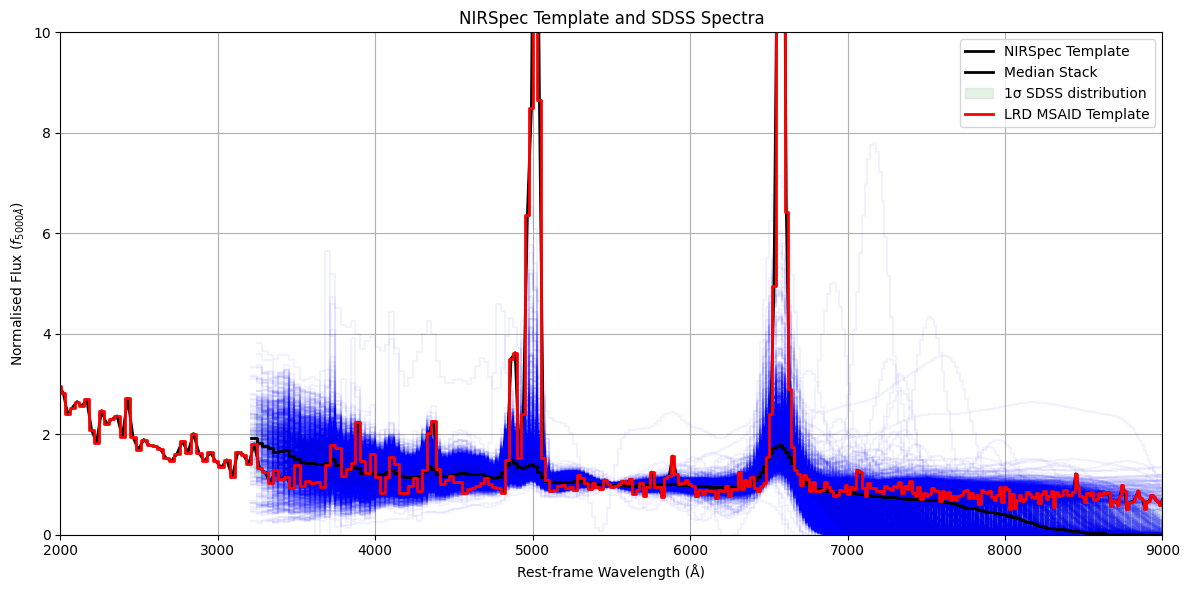

In [42]:
NLS1.quick_plot(SDSS_=True, Stacked_SDSS=True, LRD_MSAID=True)

(0.0, 10.0)

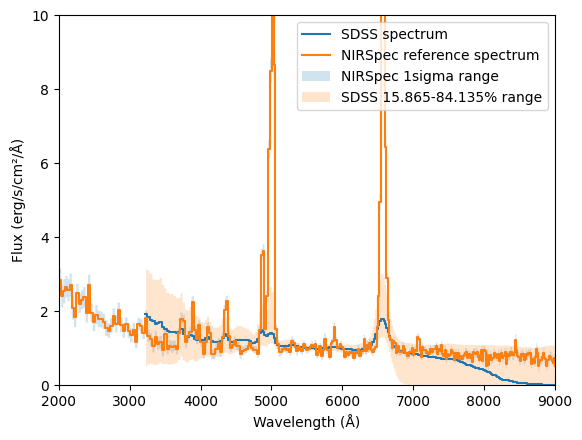

In [43]:
plt.step(NLS1.restframe, NLS1.stacked[3],where='mid', label='SDSS spectrum')
plt.step(NLS1.restframe, NLS1.NIRSpec_flux_normalized,where='mid', label='NIRSpec reference spectrum')
plt.fill_between(NLS1.restframe,
                    NLS1.NIRSpec_flux_normalized-NLS1.NIRSpec_sigma_normalized,
                    NLS1.NIRSpec_flux_normalized+NLS1.NIRSpec_sigma_normalized,
                    alpha=0.2,step='mid', label='NIRSpec 1sigma range')
plt.fill_between(NLS1.restframe,
                 NLS1.Stack(sig=True)[1],
                 NLS1.Stack(sig=True)[5],
                 alpha=0.2, step='mid',label='SDSS 15.865-84.135% range')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux (erg/s/cm²/Å)')
plt.legend()
plt.xlim(2000, 9000)
plt.ylim(0, 10)


In [44]:
NLS1.Stack(sig=True)

Re‑binning SDSS spectra:   0%|          | 0/11066 [00:00<?, ?it/s]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [71]:
Stable=fits.open('Data/result')[1].data
sp_id= Stable['sp-id']
parts  = np.array([s.split('-') for s in sp_id])
plate= parts[:, 0].astype(int)
mjd= parts[:, 1].astype(int)
fiber= parts[:, 2].astype(int)
ra= Stable['RAJ2000']
dec= Stable['DEJ2000']
z_spec= Stable['z']

In [ ]:
from pathlib import Path
from astroquery.sdss import SDSS
import astropy.io.fits as fits

def fetch_sdss_spectra(id_strings,
                       data_release=17,        # change if you need an older DR
                       save=True,
                       outdir="spectra",
                       show_progress=True):
    """
    Download SDSS/BOSS spectra specified by plate-MJD-fiber.

    Parameters
    ----------
    id_strings   : iterable of str
        Each element must look like '1234-56789-321'.
    data_release : int, optional
        Public SDSS data release to query (DR 17 is the latest as of 2025).
    save         : bool, optional
        If True, write each spectrum to <outdir>/spec-plate-mjd-fiber.fits
        and still return it in the 'spectra' list.
    outdir       : str or Path
        Directory where FITS files are written (created if missing).
    show_progress: bool
        Forwarded to SDSS.get_spectra so you can watch the download bar.

    Returns
    -------
    spectra : list of `astropy.io.fits.HDUList`
        One entry per successfully retrieved spectrum.
    """
    outdir = Path(outdir)
    if save:
        outdir.mkdir(exist_ok=True)

    spectra = []
    for obj in id_strings:
        try:
            plate, mjd, fiber = map(int, obj.split('-'))
        except ValueError:
            print(f"⚠️  Bad format (expected 'plate-mjd-fiber'): {obj}")
            continue

        try:
            # astroquery.sdss returns a *list* (usually length 1)
            spec_list = SDSS.get_spectra(
                plate=plate,
                mjd=mjd,
                fiberID=fiber,
                data_release=data_release,
                cache=True,
                show_progress=show_progress
            )                                # 
        except Exception as exc:
            print(f"⚠️  Network/HTTP error for {obj}: {exc}")
            continue

        if not spec_list:
            print(f"⚠️  No spectrum found for {obj}")
            continue

        spec = spec_list[0]                 # keep the HDUList
        spectra.append(spec)

        if save:
            fname = outdir / f"spec-{plate:04d}-{mjd}-{fiber:04d}.fits"
            spec.writeto(fname, overwrite=True)
            print(f"✅  Saved {fname}")

    return spectra

In [ ]:
def armindex(a, v):
    """
    Return the index of the value closest to v in a.
    """
    idx = (np.abs(a - v)).argmin()
    return idx

In [ ]:
SDSS_viewer(fits_files[0])

FITS_rec([(-2.6223714, 3.5581, 0.03898722, 0, 0, 1.3361597 ,  4.052089 , 4.7204914),
          (10.257659 , 3.5582, 0.03985139, 0, 0, 1.3361211 ,  4.4584727, 4.7340035),
          (13.146721 , 3.5583, 0.04050886, 0, 0, 1.3360822 ,  4.686143 , 4.6970277),
          ...,
          (-1.5582304, 4.0148, 0.05754149, 0, 0, 0.90658456, 26.684912 , 1.6719486),
          ( 6.2943125, 4.0149, 0.03412403, 0, 0, 0.90735   , 60.51033  , 1.649156 ),
          (-1.9979566, 4.015 , 0.03479384, 0, 0, 0.9081177 , 47.958973 , 1.6187304)],
         dtype=(numpy.record, [('flux', '>f4'), ('loglam', '>f4'), ('ivar', '>f4'), ('and_mask', '>i4'), ('or_mask', '>i4'), ('wdisp', '>f4'), ('sky', '>f4'), ('model', '>f4')]))

In [ ]:
def SDSS_viewer(file):
    data= fits.open(file)
    
    # # Name
    # name= file.split('/')[-1][5:-5]
    # # Extract data from the FITS file
    # Lam= 10**data[1].data['loglam']
    # # Find the redshift
    # z=z_spec[np.where(sp_id == name)[0][0]]
    # lam= Lam / (1 + z)
    # norm_idx= armindex(lam, 5500)  # Find index for normalization
    # flux= data[1].data['flux']
    # model= data[1].data['model']
    # model = model / model[norm_idx]  # Normalize the model
    

    # lam = lam[lam_flag]
    # model = model[lam_flag]

    
    # return lam,model
    return data[1].data

In [48]:
import glob
from tqdm.notebook import tqdm
fits_files = list(glob.glob("spectra_v2_NLSy1/*.fits"))

In [3]:
fits.open(fits_files[0])[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   32 / length of dimension 1                          
NAXIS2  =                 4593 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    8 / number of table fields                         
TTYPE1  = 'flux    '                                                            
TFORM1  = 'E       '                                                            
TTYPE2  = 'loglam  '                                                            
TFORM2  = 'E       '                                                            
TTYPE3  = 'ivar    '        

In [ ]:
len(fits_files)

11066

In [49]:
Hbeta_EW = []
name= []
for f in fits_files:
    data = fits.open(f)
    Hbeta_EW_i=data[3].data['LINEEW'][15]
    if Hbeta_EW_i >= 0:
        Hbeta_EW.append(Hbeta_EW_i)
    else:
        Hbeta_EW.append(np.nan)


    name.append(data[3].data['LINENAME'][15])


[]

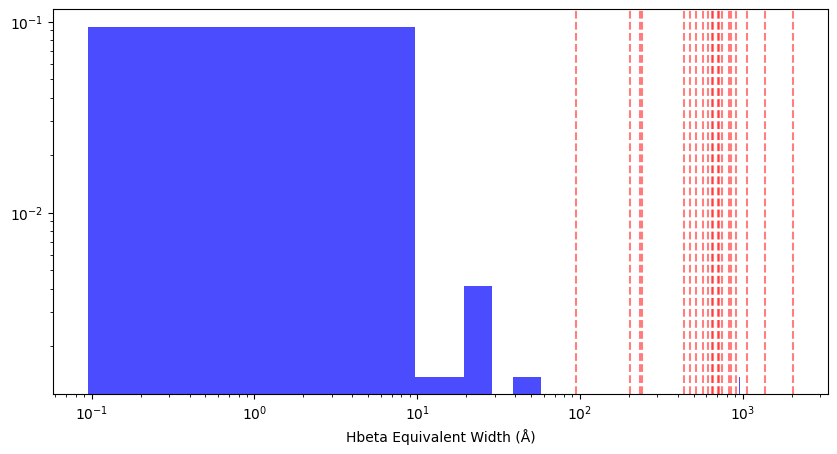

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(Hbeta_EW, bins=100, color='blue', alpha=0.7, density=True)
for i in hbeta_eq_lrd:
    ax.axvline(i, color='red', linestyle='--', alpha=0.5, label='LRD Hbeta EW')
ax.set_xlabel('Hbeta Equivalent Width (Å)')
ax.loglog()

In [81]:
def Normalized(flux, std, lam):
    """Normalize the flux using a weighted mean computed over 5300-5700 Angstrom."""
    region = (lam > 5400) & (lam < 5600)
    # Using the inverse variance as weights.
    if np.nansum(1/std[region]**2) is np.inf:
        print("Warning: No valid region for normalization, returning unnormalized flux.")
        return flux/np.nanmean(flux[region]), 1.0
    np.where(std == 0, np.nan, std)  # Avoid division by zero in normalization
    # print(1/std[region]**2)
    mean_flux = np.average(flux[region], weights=1/std[region]**2,)
    mean_std = 1/np.sqrt(np.nansum(1/std[region]**2)) 
    normalized_std = np.sqrt((mean_std/mean_flux)**2+(std/flux)**2)*(flux/mean_flux)
    return flux / mean_flux, normalized_std

In [ ]:
lambda_LRD

In [50]:
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import matplotlib.pyplot as plt
lambda_LRD = []
stacked_median_flux = []
sigma=[]
upper_flux = []
lowwer_flux = []
percentiles = []
flux_LRD = []
Number_of_stack_nan_in_bin=[]
SRC_id=[]

points_3500 = []
points_7500 = []
points_3000 = []
points_7250 = []
from concurrent.futures import ThreadPoolExecutor

def rebinned_AGN(target_wave):
    """Create empty containers for the results using parallel processing."""
    
    def resample(Resolution, wave_NIRSpec, SDSS_wave, SDSS_flux):
        # return msaexp.resample.resample_template(wave_NIRSpec,
        #                                          Resolution,
        #                                          SDSS_wave,
        #                                          SDSS_flux,
        #                                          wave_min=SDSS_wave.min()+100,
        #                                          wave_max=SDSS_wave.max()-150,
        #                                          fill_value=np.nan)
        return spectres(
            wave_NIRSpec,
            SDSS_wave,
            SDSS_flux,
            fill=np.nan,
            verbose=False
        )
    
    

    def normalize_flux(resampled_flux, flux, ivar, lam):
        region = (lam > 5250) & (lam < 5350)
        if np.nansum(ivar[region]) == 0:
            return resampled_flux/np.nanmean(flux[region]), np.nan
        ivar_region = ivar[region].copy()
        ivar_region[ivar_region == 0] = np.nan
        mean_flux = np.average(flux[region], weights=ivar_region)
        weight_norm = 1 / np.sqrt(np.nansum(ivar[region]))
        return resampled_flux/mean_flux, weight_norm

    def process_file(file):
        fname = file.split('/')[-1]
        srcid = fname[5:-5]
        parts = file.split('-')
        plate_val = parts[0][5:]
        mjd_val = parts[1]
        fiber_val = parts[2][:-5]
        
        data = fits.open(file)
        # Find redshift from global sp_id and z_spec
        idx = np.where(sp_id == srcid)[0]
        if len(idx) > 0:
            z = z_spec[idx][0]
        else:
            z = np.nan
        lam_arr = 10**data[1].data['loglam']
        flux_arr = data[1].data['flux']
        ivar_arr = data[1].data['ivar']
        ivar_arr[ivar_arr == 0] = np.nan  # avoid div by 0

        model_arr = data[1].data['model']
        weight = np.nanmedian(ivar_arr)
        Target_at_AGN = target_wave * (1 + z)
        L_lam, L_R = Target_at_AGN, Resolution(Target_at_AGN)

        # tar_mask= (Target_at_AGN >= lam_arr.min()) & (Target_at_AGN <= lam_arr.max())
        # L_lam = L_lam[tar_mask]
        # L_R = L_R[tar_mask]
        resampled = resample(L_R, L_lam, lam_arr, model_arr)
        resampled[resampled == 0] = np.nan
        
        norm_flux, weight_norm = normalize_flux(resampled, flux_arr, ivar_arr, lam_arr/(1+z))
        norm_flux[norm_flux == 0] = np.nan
        norm_flux[target_wave > 8500] = np.nan  # Avoid high wavelength regions
        return (lam_arr, flux_arr, ivar_arr, model_arr, z, plate_val, mjd_val, fiber_val,
                resampled, weight, norm_flux, weight_norm)

    # Use ThreadPoolExecutor to process files concurrently.
    with ThreadPoolExecutor() as executor:
        results_list = list(tqdm(executor.map(process_file, fits_files),
                                 total=len(fits_files),
                                 desc="Processing FITS files"))

    # Unzip the results into separate lists.
    Lambda, Flux, Invar, Model, zspec, Plate, MJD, FiberID, \
    Resampled_SDSS_PRISM, SDSS_PRISM_weight, \
    Resampled_norm_SDSS_PRISM, SDSS_PRISM_weight_norm = zip(*results_list)

    # Return results as lists.
    return (list(Lambda), list(Flux), list(Invar), list(Model), list(zspec),
            list(Plate), list(MJD), list(FiberID), list(Resampled_SDSS_PRISM),
            list(SDSS_PRISM_weight), list(Resampled_norm_SDSS_PRISM),
            list(SDSS_PRISM_weight_norm))



def plot_interpolated_spectrum(idx):
    LRD = get_spectrum_from_dja(row[idx])
    target_wave = LRD.spec['wave'] * 10000 / (1 + row[idx]['z_best'])

    (Lambda, Flux, Invar, Model, zspec, Plate, MJD, FiberID,
     Resampled_SDSS_PRISM, SDSS_PRISM_weight, Resampled_norm_SDSS_PRISM,
     SDSS_PRISM_weight_norm) = rebinned_AGN(target_wave)

    # Replace 0s with NaN in spectra
    inter = [np.where(spec == 0, np.nan, spec) for spec in Resampled_norm_SDSS_PRISM]

    results = {
        'Lambda': Lambda,
        'Flux': Flux,
        'Invar': Invar,
        'Model': Model,
        'zspec': zspec,
        'Plate': Plate,
        'MJD': MJD,
        'FiberID': FiberID,
        'Resampled_SDSS_PRISM': Resampled_SDSS_PRISM,
        'SDSS_PRISM_weight': SDSS_PRISM_weight,
        'Resampled_norm_SDSS_PRISM': Resampled_norm_SDSS_PRISM,
        'SDSS_PRISM_weight_norm': SDSS_PRISM_weight_norm,
        'Interpolated_Spectrum': inter
    }

    target_3500_idx = np.abs(target_wave - 3500).argmin()
    target_3000_idx = np.abs(target_wave - 3000).argmin()
    target_7500_idx = np.abs(target_wave - 7500).argmin()
    target_7250_idx = np.abs(target_wave - 7250).argmin()


    list_3500 = [s[target_3500_idx] for s in inter if not np.isnan(s[target_3500_idx])]
    list_7500 = [s[target_7500_idx] for s in inter if not np.isnan(s[target_7500_idx])]
    list_3000 = [s[target_3000_idx] for s in inter if not np.isnan(s[target_3000_idx])]
    list_7250 = [s[target_7250_idx] for s in inter if not np.isnan(s[target_7250_idx])]
    # Append the lists to the respective points lists
    points_3500.append(list_3500)
    points_7500.append(list_7500)
    points_3000.append(list_3000)
    points_7250.append(list_7250)

    interp_array = np.array(inter)
    mean_interp = np.nanmedian(interp_array, axis=0)
    percentiles_array = np.nanpercentile(interp_array, [0.135, 2.275,15.865,50,84.135,97.725,99.865], axis=0)
    low, median, upp = percentiles_array[2], percentiles_array[3], percentiles_array[4]
    sigma.append((percentiles_array[-2] - percentiles_array[1])/4)
    xlow = target_wave[~np.isnan(mean_interp)].min()
    xhigh = 8500

    Normalized_LRD, Normalized_LRD_err = Normalized(
        LRD.spec['flux'] * LRD.spec['to_flam'],
        1 / LRD.spec['err'] ** 2,
        target_wave
    )

    # Define exclusion lines with their exclusion widths
    line_exclusions = {
        "OIII":   (5007, 100),
        "Hbeta":  (4861.35, 200),
        "Halpha": (6562.79, 300),
        "Hgamma": (4340.472, 100),
        "Hdelta": (4101.734, 100),
        "MgII":   (2780, 100),
        "OII":    (3727, 50),
        "NeIII":  (3869, 50),
        "HeI":    (5876, 50),
        "NiII":   (6583, 50),
        "SIII":   (6722, 100),
        "HeII2":  (7065.196, 100),
        "OI":     (8446.359, 50),
    }

    mask = (target_wave > xlow) & (target_wave < xhigh)
    for center, exclusion in line_exclusions.values():
        mask &= np.abs(target_wave - center) > exclusion

    # chisquare = np.nansum((mean_interp[mask] - Normalized_LRD[mask])**2 / ((upp[mask]-low[mask])/6)**2)
    # print(f"Chi-square for the fit: {chisquare:.2f}")

    # Plotting
    plt.figure(figsize=(12, 8))
    for spec in inter:
        plt.plot(target_wave, spec, lw=0.1, alpha=0.02, color='C0')
    plt.step(target_wave, mean_interp, lw=1, color='red', where='mid', label='Median NL Seyfert Spectrum')
    plt.fill_between(target_wave, low, upp,where=mask, color='orange', alpha=0.4)
    plt.step(target_wave, Normalized_LRD, where='mid', color='g', lw=1, label=f'LRD Spectrum (z={row[idx]["z_best"]:.2f})')

    for line_center, _ in line_exclusions.values():
        plt.axvline(line_center, color='k', lw=0.5, ls='--')

    plt.axhline(1, color='k', lw=0.5, ls='--')
    plt.xlabel(r'Restframe Wavelength ($\lambda$) [$\AA$]')
    plt.ylabel(r'Relative Flux Density [$f_{5300Å}$]')
    plt.title(f'SRCID: {row[idx]["srcid"]}')
    plt.xlim(xlow, xhigh)
    plt.ylim(0, 10)
    plt.legend()
    plt.show()

    # Save results
    lambda_LRD.append(target_wave)
    stacked_median_flux.append(mean_interp)
    upper_flux.append(upp)
    lowwer_flux.append(low)
    percentiles.append([0.14, 2.28, 15.87, 50, 84.13, 97.72, 99.86])
    flux_LRD.append(Normalized_LRD)
    Number_of_stack_nan_in_bin.append(np.sum(np.isnan(interp_array), axis=0))
    SRC_id.append(row[idx]['srcid'])

# Example usage:
for i in range(len(row))[:1]:
    print(f"Processing row {i+1}/{len(row)}: {row[i]['srcid']}")
    plot_interpolated_spectrum(i)


Processing row 1/11: 1244


Processing FITS files:   0%|          | 0/4925 [00:00<?, ?it/s]

NameError: name 'sp_id' is not defined

In [ ]:
from astropy.table import Table

In [ ]:
tab=Table([lambda_LRD, stacked_median_flux, sigma, percentiles, flux_LRD, Number_of_stack_nan_in_bin, SRC_id],names=['lambda_LRD', 'stacked_median_flux', 'sigma', 'percentiles', 'flux_LRD', 'Number_of_stack_nan_in_bin', 'SRC_id'])
tab.write('stacked_spectra.fits', overwrite=True)

In [ ]:
Tab=fits.open('stacked_spectra.fits')[1].data

In [ ]:
lambda_LRD = Tab['lambda_LRD']
stacked_median_flux = Tab['stacked_median_flux']
sigma= Tab['sigma']

flux_LRD = Tab['flux_LRD']
# Number_of_stack_nan_in_bin=[]
SRC_id= Tab['SRC_id']


# Retrying the stacking code



In [ ]:
class SDSS_stacker_v2:

    def __init__(self,
                 SDSS_catalogue: str,
                 T,
                 SDSS_file_location: str,
                 NIRSpec_table_row,
                 Resolution,
                 *,
                 max_workers: int | None = None,):
        
        with fits.open(SDSS_catalogue, memmap=True, lazy_load_hdus=True) as hdul:
            self.SDSS_catalogue = hdul[T].data
        self.SDSS_file_location = SDSS_file_location
        self.SDSS_files = glob.glob(f"{SDSS_file_location}/spec-*.fits")
        self._z_by_sdss_id = {sdssrow['P-M-F']: sdssrow['Zs'] for sdssrow in self.SDSS_catalogue}

        url_tpl = "https://s3.amazonaws.com/msaexp-nirspec/extractions/{root}/{file}"
        self.NIRSpec = msaexp.spectrum.SpectrumSampler(url_tpl.format(**NIRSpec_table_row)).spec
        self.row = NIRSpec_table_row
        self.restframe = self.NIRSpec["wave"] * 1e4 / (1.0 + self.row["z_best"])
        with fits.open(Resolution, memmap=True, lazy_load_hdus=True) as hdul:
            nirspec_R_data = hdul[1].data
            _R_wave = nirspec_R_data["wavelength"] * 1e4 
            _R_val = nirspec_R_data["R"]

        def _R_interp(L: np.ndarray | float) -> np.ndarray:
            return np.interp(L, _R_wave, _R_val, left=np.nan, right=np.nan)
        self.R_nirspec = _R_interp


        self._max_workers = max_workers

        # Caches -------------------------------------------------------
        self.rebinned_spectra: np.ndarray | None = None  # (N_pix, N_spec)
        self.rebinned_sigma:   np.ndarray | None = None  # (N_pix, N_spec)
        self.stacked:          np.ndarray | None = None  # percentiles across specs

        self.bootstrapped_spectra: np.ndarray | None = None  # (N_pix, N_spec*n_boot)
        self.bootstrapped_stack:   np.ndarray | None = None  # percentiles across boot stacks

        # Normalised NIRSpec placeholders ------------------------------
        self.NIRSpec_flux_normalized:  np.ndarray | None = None
        self.NIRSpec_sigma_normalized: np.ndarray | None = None

    # ------------------------------------------------------------------
    # Normalise the NIRSpec template to f_5000 = 1

    def _normalise_nirspec(self, region: tuple[float, float]):


        nir_flux  = self.NIRSpec["flux"] * self.NIRSpec["to_flam"]
        nir_sigma = self.NIRSpec["err"]  * self.NIRSpec["to_flam"]

        mask = (self.restframe > region[0]) & (self.restframe < region[1])
        nir_mean = np.nanmean(nir_flux[mask])

        nir_flux_n = nir_flux / nir_mean
        nir_flux_n[~np.isfinite(nir_flux_n)] = np.nan
        self.NIRSpec_flux_normalized = nir_flux_n

        # error propagation of division by mean
        sigma_mean = np.sqrt(np.nansum(nir_sigma[mask] ** 2)) / np.sum(mask)
        nir_sigma_n = np.sqrt((nir_sigma / nir_mean) ** 2 + (nir_flux_n * sigma_mean / nir_mean) ** 2)
        nir_sigma_n[~np.isfinite(nir_sigma_n)] = np.nan
        self.NIRSpec_sigma_normalized = nir_sigma_n

    def resample_and_normalize_sdss(
        self,
        Lambda: np.ndarray,
        flux: np.ndarray,
        z_sdss: float,
        *,
        sig: bool = False,
        region: tuple[float, float] = (5400.0, 5600.0),
    ) -> np.ndarray | tuple[np.ndarray, np.ndarray]:
        """Resample a single SDSS spectrum onto the NIRSpec grid and normalise.

        Parameters
        ----------
        Lambda : (N_pix,) target wavelength grid (rest-frame)
        flux   : (N_pix_orig,) original SDSS flux array
        z_sdss : redshift of the SDSS spectrum
        sig    : if True, also return propagated uncertainties
        region : wavelength range for normalisation

        Returns
        -------
        If ``sig=False``, returns ``(N_pix,)`` resampled & normalised flux.
        If ``sig=True``, returns ``(N_pix,)`` resampled & normalised flux and propagated sigma.
        """
        if self.NIRSpec_flux_normalized is None or self.NIRSpec_sigma_normalized is None:
            self._normalise_nirspec(region)

        # Observed-frame wavelength grid for this SDSS spectrum
        obs_wave = Lambda * (1.0 + z_sdss)

# redden the spectra 

In [ ]:
masking= []
bestfit_Av= []

In [21]:
"""
Spectrum extinction fitting script
----------------------------------

This standalone script refactors your original notebook cell into a
re‑usable function that

1.   cleans up variable names,
2.   removes the duplicated normalisation step,
3.   exposes **A_V** and **F** as free parameters, and
4.   initialises the global containers so the code runs from a clean
     state each time.

It assumes the following **global arrays** have been loaded beforehand
(one entry per spectrum):

* ``lambda_LRD``  – wavelength arrays (Å)
* ``flux_LRD``    – observed flux density
* ``stacked_median_flux`` – template spectrum
* ``upper_flux`` / ``lower_flux`` – ±1σ on the template (optional)
* ``sigma``       – 1σ uncertainties on the observed flux
* ``SRC_id``      – an identifier for each spectrum

With those arrays in memory simply call ``fit_all_spectra()``.
"""

from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from dust_extinction.parameter_averages import G16
from scipy.optimize import minimize

# ────────────────────────────────────────────────────────────────────────────────
#  CONFIGURATION
# ────────────────────────────────────────────────────────────────────────────────

ext_model = G16()  # Gordon+2016 Milky‑Way average extinction curve

bestfit_Av: list[float] = []  # collects best‑fit A_V values for every spectrum
masking: list[np.ndarray] = []  # continuum masks (one per spectrum)


# ────────────────────────────────────────────────────────────────────────────────
#  CORE UTILITIES
# ────────────────────────────────────────────────────────────────────────────────

def evaluate_extinction(inv_lam: u.Quantity, F: float, RvA: float = 3.1) -> np.ndarray:
    """Return the *G16* extinction curve for a given **fA = F** parameter."""
    return ext_model.evaluate(inv_lam, RvA=RvA, fA=F)


def chi_square(data: np.ndarray, model: np.ndarray, sigma: np.ndarray) -> float:
    """Standard χ² statistic with NaNs ignored."""
    return np.nansum(((data - model) / sigma) ** 2)


# ────────────────────────────────────────────────────────────────────────────────
#  FITTING A SINGLE SPECTRUM
# ────────────────────────────────────────────────────────────────────────────────

def fit_spectrum(idx: int, Av_init: float = 0.5, F_init: float = 1.0) -> tuple[float, float, float]:
    """Fit spectrum *idx* and return (A_V, F, χ²_red)."""

    lam = lambda_LRD[idx]
    valid = (lam > 1_000) & (lam < 9_000)  # Å – same cuts as original code

    lam_ang = lam[valid] * u.angstrom
    inv_lam = 1.0 / lam_ang.to(u.micron)
    lam_val = lam_ang.value  # Å as a plain ndarray

    # ── normalisation window (rest‑frame 5250–5350 Å)
    norm_region = (lam_val > 5_250) & (lam_val < 5_350)

    # ── spectra and 1σ errors
    f_obs   = flux_LRD[idx][valid]
    f_tpl   = stacked_median_flux[idx][valid]
    err_obs = sigma[idx][valid]

    # ── strong lines to exclude from the continuum fit  (centre Å, half‑width Å)
    line_exclusions = {
        "O III":  (5_007.0, 100),
        "Hβ":     (4_861.35, 200),
        "Hα":     (6_562.79, 300),
        "Hγ":     (4_340.472, 100),
        "Hδ":     (4_101.734, 100),
        "Mg II":  (2_798.0, 100),
        "O II":   (3_727.0,  50),
        "Ne III": (3_869.0,  50),
        "He I":   (5_876.0,  50),
        "N II":   (6_583.0,  50),
        "S III":  (6_722.0, 100),
        "He II":  (7_065.2, 100),
        "O I":    (8_446.4,  50),
    }

    cont_mask = np.ones_like(lam_val, dtype=bool)
    for centre, hw in line_exclusions.values():
        cont_mask &= np.abs(lam_val - centre) > hw

    masking.append(cont_mask)

    # ── objective function for *scipy.optimize.minimize*
    def objective(p: np.ndarray) -> float:
        Av, F = p
        ext_curve = evaluate_extinction(inv_lam, F)
        mean_ext  = np.average(ext_curve[norm_region])
        norm_ext  = 10 ** (-0.4 * (ext_curve - mean_ext) * Av)
        model     = f_tpl * norm_ext
        return chi_square(f_obs[cont_mask], model[cont_mask], err_obs[cont_mask])

    result = minimize(objective, [Av_init, F_init],
                      bounds=[(0, 5), (0, 5)], method="L-BFGS-B")

    Av_best, F_best = result.x
    bestfit_Av.append(Av_best)

    # ── best‑fit model and χ²_red
    ext_curve = evaluate_extinction(inv_lam, F_best)
    mean_ext  = np.average(ext_curve[norm_region])
    norm_ext  = 10 ** (-0.4 * (ext_curve - mean_ext) * Av_best)
    model     = f_tpl * norm_ext

    dof = cont_mask.sum() - 2  # 2 free parameters
    red_chi2 = chi_square(f_obs[cont_mask], model[cont_mask], err_obs[cont_mask]) / dof

    # ── diagnostic plot
    plt.figure(figsize=(10, 5))
    plt.step(lam_val, f_obs,  where="mid", lw=1,  label="LRD")
    plt.step(lam_val, f_tpl,  where="mid", lw=1,  label="Template")
    plt.step(lam_val, model,  where="mid", lw=0.8, label="Extinguished template")

    plt.fill_between(lam_val, model - err_obs * norm_ext,
                     model + err_obs * norm_ext, where=cont_mask, alpha=0.3)

    for centre, hw in line_exclusions.values():
        plt.axvline(centre, lw=0.4, ls="--", color="k")

    plt.axhline(1.0, lw=0.4, ls="--", color="k")
    plt.xlabel(r"Rest‑frame wavelength [$\mathrm{\AA}$]")
    plt.ylabel(r"Relative flux density ($f_\lambda/f_{5300\,\AA}$)")
    plt.title(f"SRCID {SRC_id[idx]} – A_V={Av_best:.2f}, F={F_best:.2f}, χ²ᵣ={red_chi2:.2f}")
    plt.ylim(0, 10)
    plt.xlim(lam_val.min(), lam_val.max())
    plt.legend()
    plt.tight_layout()
    plt.show()

    return Av_best, F_best, red_chi2


# ────────────────────────────────────────────────────────────────────────────────
#  CONVENIENCE WRAPPER
# ────────────────────────────────────────────────────────────────────────────────

def fit_all_spectra(Av_init: float = 0.5, F_init: float = 1.0):
    """Loop over every spectrum in the global arrays."""
    n_spec = len(lambda_LRD)
    print(f"Found {n_spec} spectra – starting fit…")

    results = []
    for i in range(n_spec):
        print(f"[{i+1}/{n_spec}] fitting SRCID {SRC_id[i]} …")
        results.append(fit_spectrum(i, Av_init, F_init))

    return np.asarray(results)


# ────────────────────────────────────────────────────────────────────────────────
#  END OF MODULE
# ────────────────────────────────────────────────────────────────────────────────

# Example usage:
fit_all_spectra(Av_init=0.5, F_init=1.0)


NameError: name 'lambda_LRD' is not defined

Dust law with MCMC fitting



In [46]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from scipy.optimize import curve_fit
from dust_extinction.averages import G24_SMCAvg   # Gordon+ 2024 SMC average law

# ──────────────────────────────────────────────────────────────────────────
#  GLOBAL CONSTANTS / HELPERS
# ──────────────────────────────────────────────────────────────────────────
EXT_MODEL = G24_SMCAvg()                # one instance is enough

LINE_EXCLUSIONS = {                     # centres [Å], half-widths [Å]
    "OIII":  (5007.000, 100),
    "Hβ":    (4861.350, 200),
    "Hα":    (6562.790, 300),
    "Hγ":    (4340.472, 100),
    "Hδ":    (4101.734, 100),
    "Mg II": (2780.000, 100),
    "O II":  (3727.000,  50),
    "Ne III":(3869.000,  50),
    "He I":  (5876.000,  50),
    "N II":  (6583.000,  50),
    "S III": (6722.000, 100),
    "He II": (7065.196, 100),
    "O I":   (8446.359,  50),
}

def _mask_continuum(wave):
    """Boolean array: True where *not* in any emission-line window."""
    mask = np.ones_like(wave, dtype=bool)
    for _, (c, hw) in LINE_EXCLUSIONS.items():
        mask &= np.abs(wave - c) > hw
    return mask


# ──────────────────────────────────────────────────────────────────────────
#  MAIN FITTING + PLOTTING ROUTINE
# ──────────────────────────────────────────────────────────────────────────
def fit_and_plot_weighted(idx, av_bounds=(0.0, 5.0)):
    """
    Inverse-variance weighted SMC fit for spectrum `idx`
    and plot only the best-fit model.
    """
    # 1. Slice this spectrum to 2000–8500 Å
    lam_all = lambda_LRD[idx]                          # Å
    rng     = (lam_all > 2000) & (lam_all < 8500)
    lam     = lam_all[rng]
    data    = flux_LRD[idx][rng]
    stack   = stacked_median_flux[idx][rng]
    sig     = sigma[idx][rng]

    # 2. Extinction shape evaluated once & anchored at 5300 Å
    A_by_Av = EXT_MODEL(lam * u.AA)                    # Aλ / AV
    anchor  = np.mean(A_by_Av[(lam > 5250) & (lam < 5350)])
    A_rel   = A_by_Av - anchor                        # now zero at 5300 Å

    # 3. Build continuum + finite-value mask
    cont    = _mask_continuum(lam)
    finite  = (
        np.isfinite(data) & np.isfinite(stack) &
        np.isfinite(sig)  & (sig > 0)
    )
    mask = cont & finite
    if mask.sum() < 3:
        raise RuntimeError(f"Spectrum {idx}: too few valid continuum points.")

    lam_c, data_c, stack_c, sig_c = lam[mask], data[mask], stack[mask], sig[mask]

    # 4. Model wrapper for curve_fit (lam grid is fixed)
    def model(dummy, Av):
        return stack_c * 10**(-0.4 * A_rel[mask] * Av)

    # 5. Weighted least-squares fit
    popt, pcov = curve_fit(
        model,
        xdata = lam_c,            # dummy input
        ydata = data_c,
        p0    = 0.5,              # starting guess
        sigma = sig_c,
        absolute_sigma = True,
        bounds = av_bounds,
    )
    Av_best = popt[0]
    Av_err  = np.sqrt(pcov[0, 0])

    # 6. Reduced χ² on the same points
    chi2    = np.sum(((data_c - model(None, Av_best)) / sig_c) ** 2)
    chi2_rd = chi2 / (len(data_c) - 1)                # ν = N − 1 (one param)

    # 7. Best-fit model on full λ grid
    dim_all  = 10**(-0.4 * A_rel * Av_best)
    reddened = stack * dim_all

    # 8. Plot
    plt.figure(figsize=(10, 5))
    plt.step(lam, data,       where='mid', lw=1,  color='g', label='PRISM data')
    plt.step(lam, reddened,   where='mid', lw=1,  color='orange',
             label=fr'Stack × dust  (A$_V$ = {Av_best:.2f}±{Av_err:.2f})')
    plt.fill_between(
        lam,
        reddened - sig*dim_all,
        reddened + sig*dim_all,
        where=_mask_continuum(lam), color='orange', alpha=0.30
    )

    for c, _ in LINE_EXCLUSIONS.values():
        plt.axvline(c, ls='--', lw=0.4, color='k')

    plt.axhline(1, ls='--', lw=0.5, color='k')
    plt.xlim(lam.min(), lam.max())
    plt.ylim(0, None)
    plt.xlabel(r'Rest-frame wavelength [$\AA$]')
    plt.ylabel(r'Flux / $f_{5300}$')
    plt.title(f"SRCID {SRC_id[idx]}   •   χ²$_{{red}}$ = {chi2_rd:.2f}")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ──────────────────────────────────────────────────────────────────────────
#  DRIVER LOOP
# ──────────────────────────────────────────────────────────────────────────
for i in range(len(lambda_LRD))[:]:
    print(f"Processing spectrum {i+1}/{len(lambda_LRD)}")
    fit_and_plot_weighted(i)


NameError: name 'lambda_LRD' is not defined

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from dust_extinction.averages import G24_SMCAvg   # SMC average law

ext = G24_SMCAvg()
AV_GRID = [0, 0.1,0.25, 0.5,0.75, 1.0, 1.25, 1.5,1.75,2.0]

# line windows to exclude (half-widths in Å)
LINE_EXCLUSIONS = {
    "OIII":  (5007.000, 100),
    "Hβ":    (4861.350, 200),
    "Hα":    (6562.790, 300),
    "Hγ":    (4340.472, 100),
    "Hδ":    (4101.734, 100),
    "Mg II": (2780.000, 100),
    "O II":  (3727.000,  50),
    "Ne III":(3869.000,  50),
    "He I":  (5876.000,  50),
    "N II":  (6583.000,  50),
    "S III": (6722.000, 100),
    "He II": (7065.196, 100),
    "O I":   (8446.359,  50),
}

def _continuum_mask(wave):
    m = np.ones_like(wave, dtype=bool)
    for _, (c, hw) in LINE_EXCLUSIONS.items():
        m &= np.abs(wave - c) > hw
    return m

def run_grid(idx, av_list=AV_GRID):
    # ------------- slice the pre-computed arrays --------------------------
    lam_full = lambda_LRD[idx]                # Å
    use      = (lam_full > 2000) & (lam_full < 8500)
    lam      = lam_full[use]
    lrd      = flux_LRD[idx][use]
    stack    = stacked_median_flux[idx][use]
    sigma_i  = sigma[idx][use]

    # extinction shape Aλ/AV evaluated once
    A_over_Av = ext(lam * u.AA)               # dimensionless
    # anchor so mean in 5250–5350 Å is zero
    anchor    = np.mean(A_over_Av[(lam > 5250) & (lam < 5350)])
    A_rel     = A_over_Av - anchor

    cont_mask = _continuum_mask(lam)
    dof       = cont_mask.sum() - 1           # one free parameter (AV)

    # ------------- figure setup -------------------------------------------
    n = len(av_list)
    ncols = 2
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(25, 15),
                             sharex=True, sharey=True)
    axes = axes.flatten()

    # ------------- loop over AV values ------------------------------------
    for j, AV in enumerate(av_list):
        ax = axes[j]

        extinction  = 10**(-0.4 * A_rel * AV)      # dimming factor
        reddened    = stack * extinction

        # χ² on continuum points
        chi2 = np.nansum(((lrd[cont_mask] - reddened[cont_mask]) /
                       (sigma_i[cont_mask] * extinction[cont_mask]))**2)
        chi2_red = chi2 / dof

        # plot
        ax.step(lam, lrd,           where='mid', lw=0.8, color='g')
        ax.step(lam, reddened,      where='mid', lw=0.8, color='orange')
        ax.fill_between(lam,
                        reddened - sigma_i*extinction,
                        reddened + sigma_i*extinction,
                        where=cont_mask, color='orange', alpha=0.3)
        for c, _ in LINE_EXCLUSIONS.values():
            ax.axvline(c, ls='--', lw=0.4, color='k')

        ax.set_title(f"A$_{{V}}$ = {AV}  •  χ²$_{{red}}$ = {chi2_red:.2f}",
                     fontsize=9)

    # tidy unused axes if AV list isn’t a multiple of ncols
    for k in range(n, nrows*ncols):
        fig.delaxes(axes[k])

    fig.suptitle(f"SRCID: {SRC_id[idx]}", fontsize=14)
    fig.supxlabel("Rest-frame wavelength (Å)")
    fig.supylabel("Flux / $f_{5300}$")
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ----------------------- driver loop ----------------------------------------
for i in range(len(lambda_LRD)):
    print(f"Processing spectrum {i+1}/{len(lambda_LRD)}")
    run_grid(i)


NameError: name 'lambda_LRD' is not defined

# some stats


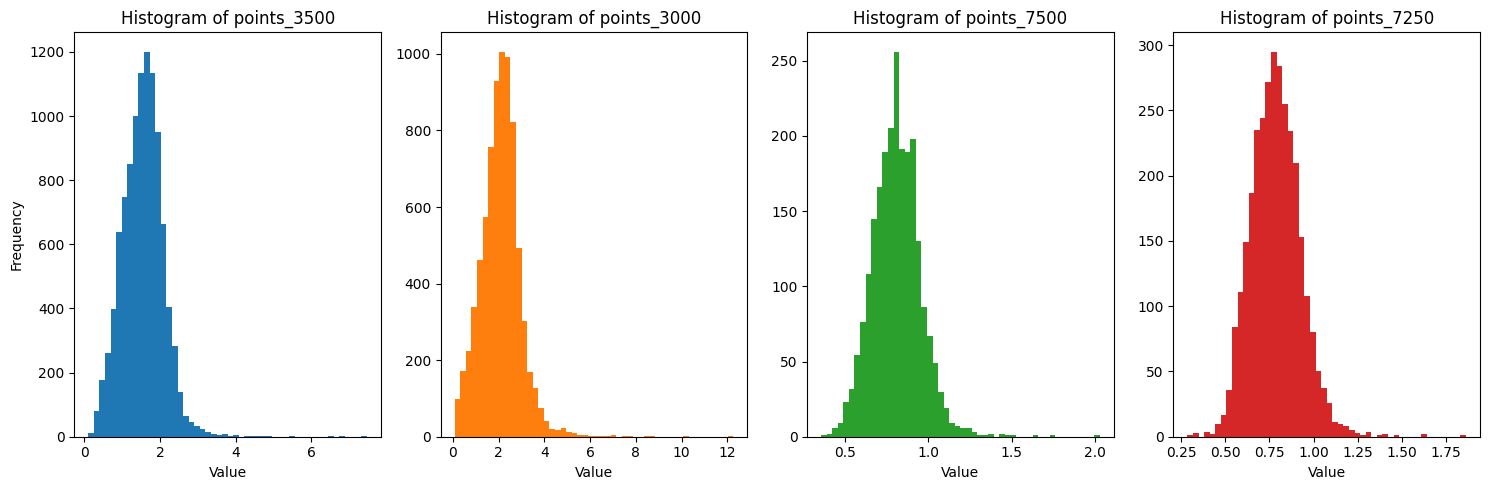

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.hist(points_3500, bins=50, color='C0')
plt.title("Histogram of points_3500")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.subplot(1, 4, 2)
plt.hist(points_3000, bins=50, color='C1')
plt.title("Histogram of points_3000")
plt.xlabel("Value")

plt.subplot(1, 4, 3)
plt.hist(points_7500, bins=50, color='C2')
plt.title("Histogram of points_7500")
plt.xlabel("Value")
plt.subplot(1, 4, 4)
plt.hist(points_7250, bins=50, color='C3')
plt.title("Histogram of points_7250")
plt.xlabel("Value")

plt.tight_layout()
plt.show()

In [ ]:
Mean_lrd= np.nanmean(flux_LRD, axis=0)
Mean_upper_flux = np.nanmean(upper_flux, axis=0)
Mean_lower_flux = np.nanmean(lowwer_flux, axis=0)
Mean_percentiles = np.nanmean(percentiles, axis=0)

Plotting masked spectrum for SRCID: 1244


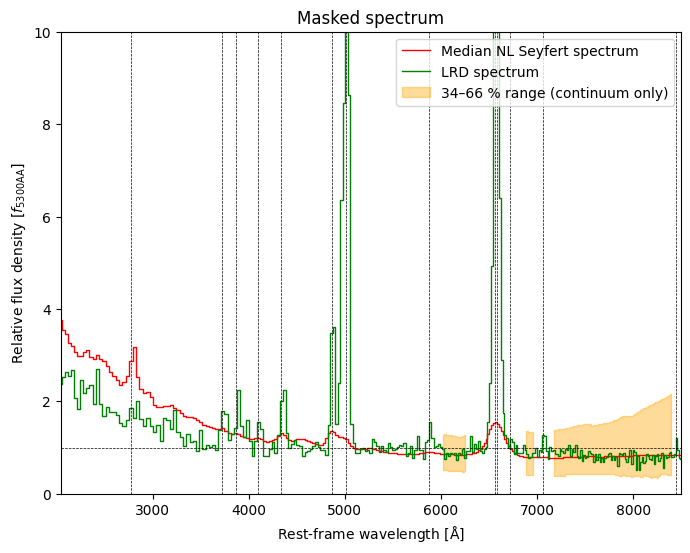

Number of points in the mask: 92


NameError: name 'chi2' is not defined

In [ ]:
def mask_test(target_wave, mean_interp, upp, low, Normalized_LRD):
    """Plot spectrum and shade the continuum-only (masked-good) region."""
    import numpy as np
    import matplotlib.pyplot as plt

    # ---- line centres (Å) ----------------------------------------------
    lines = dict(OIII=5007, Hbeta=4861.35, Halpha=6562.79,
                 Hgamma=4340.472, Hdelta=4101.734, MgII=2780,OII=3727,NeIII=3869,HeI=5876,NiII=6583,SIII=6722,HeII2=7065.196,OI=8446.359)

    # ---- build “good-continuum” mask -----------------------------------
    Normalized_LRD[Normalized_LRD==0]=np.nan
    xlow  = target_wave[~np.isnan(mean_interp) & ~np.isnan(Normalized_LRD)].min()
    xhigh = target_wave[~np.isnan(mean_interp) & ~np.isnan(Normalized_LRD)].max()

    mask = (
        (target_wave > xlow) & (target_wave < xhigh) &
        (np.abs(target_wave - lines["Hbeta"])  > 200) &
        (np.abs(target_wave - lines["OIII"])   > 100) &
        (np.abs(target_wave - lines["Hgamma"]) > 100) &
        (np.abs(target_wave - lines["Hdelta"]) > 100) &
        (np.abs(target_wave - lines["Halpha"]) > 300) &
        (np.abs(target_wave - lines["MgII"])   > 100) &
        (np.abs(target_wave - lines["OII"])    > 50)  &
        (np.abs(target_wave - lines["NeIII"])  > 50) &
        (np.abs(target_wave - lines["HeI"])    > 50) &
        (np.abs(target_wave - lines["NiII"])   > 50) &
        (np.abs(target_wave - lines["SIII"])   > 100) &
        (np.abs(target_wave - lines["HeII2"])  > 100) &
        (np.abs(target_wave - lines["OI"])     > 50) &
        (target_wave > 6000)
        

    )

    # ---- plotting -------------------------------------------------------
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.step(target_wave, mean_interp, lw=1, color='red',  where='mid',
            label='Median NL Seyfert spectrum')
    ax.step(target_wave, Normalized_LRD, lw=1, color='g', where='mid',
            label='LRD spectrum')

    # emission-line tick marks
    for name, lam in lines.items():
        ax.axvline(lam, color='k', lw=0.5, ls='--')

    ax.axhline(1, color='k', lw=0.5, ls='--')

    # ---- shaded 34–66 % envelope, *only where mask is True* ------------
    ax.fill_between(
        target_wave,              # x-axis = wavelength
        low, upp,                 # y-limits = envelope
        where=mask & ~np.isnan(low) & ~np.isnan(upp),
        step='mid',
        color='orange', alpha=0.4,
        label='34–66 % range (continuum only)'
    )

    ax.set_xlabel(r'Rest-frame wavelength [$\rm \AA$]')
    ax.set_ylabel(r'Relative flux density [$f_{5300\text{\AA}}$]')
    ax.set_xlim(xlow, xhigh)
    ax.set_ylim(0, 10)
    ax.set_title('Masked spectrum')
    ax.legend()
    plt.show()
    chisquare= np.sum((mean_interp[mask] - Normalized_LRD[mask])**2 / ((upp[mask]-low[mask])/2)**2)
    redchisquare = chisquare / np.sum(mask)

    print(f"Number of points in the mask: {np.sum(mask)}")
    P_value= 1 - chi2.cdf(chisquare, np.sum(mask))
    print(chi2.cdf(chisquare, np.sum(mask)))
    print(f"Chi-square: {chisquare:.5f}, Reduced Chi-square: {redchisquare:.5f}, P-value: {P_value:.5f}")

# Example usage of the mask_test function
for i in range(len(lambda_LRD))[:]:
    print(f"Plotting masked spectrum for SRCID: {SRC_id[i]}")
    mask_test(lambda_LRD[i], stacked_median_flux[i], upper_flux[i], lowwer_flux[i], flux_LRD[i])

In [ ]:
def mask_test(target_wave, mean_interp, upp, low, Normalized_LRD):
    """Plot spectrum and shade the continuum-only (masked-good) region."""
    import numpy as np
    import matplotlib.pyplot as plt

    # ---- line centres (Å) ----------------------------------------------
    lines = dict(OIII=5007, Hbeta=4861.35, Halpha=6562.79,
                 Hgamma=4340.472, Hdelta=4101.734, MgII=2780,OII=3727,NeIII=3869,HeI=5876,NiII=6583,SIII=6722,HeII2=7065.196,OI=8446.359)

    # ---- build “good-continuum” mask -----------------------------------
    Normalized_LRD[Normalized_LRD==0]=np.nan
    xlow  = target_wave[~np.isnan(mean_interp) & ~np.isnan(Normalized_LRD)].min()
    xhigh = target_wave[~np.isnan(mean_interp) & ~np.isnan(Normalized_LRD)].max()

    mask = (
        (target_wave > xlow) & (target_wave < xhigh) &
        (np.abs(target_wave - lines["Hbeta"])  > 200) &
        (np.abs(target_wave - lines["OIII"])   > 100) &
        (np.abs(target_wave - lines["Hgamma"]) > 100) &
        (np.abs(target_wave - lines["Hdelta"]) > 100) &
        (np.abs(target_wave - lines["Halpha"]) > 300) &
        (np.abs(target_wave - lines["MgII"])   > 100) &
        (np.abs(target_wave - lines["OII"])    > 50)  &
        (np.abs(target_wave - lines["NeIII"])  > 50) &
        (np.abs(target_wave - lines["HeI"])    > 50) &
        (np.abs(target_wave - lines["NiII"])   > 50) &
        (np.abs(target_wave - lines["SIII"])   > 100) &
        (np.abs(target_wave - lines["HeII2"])  > 100) &
        (np.abs(target_wave - lines["OI"])     > 50) &
        (target_wave < 4000)
        

    )

    # ---- plotting -------------------------------------------------------
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.step(target_wave, mean_interp, lw=1, color='red',  where='mid',
            label='Median NL Seyfert spectrum')
    ax.step(target_wave, Normalized_LRD, lw=1, color='g', where='mid',
            label='LRD spectrum')

    # emission-line tick marks
    for name, lam in lines.items():
        ax.axvline(lam, color='k', lw=0.5, ls='--')

    ax.axhline(1, color='k', lw=0.5, ls='--')

    # ---- shaded 34–66 % envelope, *only where mask is True* ------------
    ax.fill_between(
        target_wave,              # x-axis = wavelength
        low, upp,                 # y-limits = envelope
        where=mask & ~np.isnan(low) & ~np.isnan(upp),
        step='mid',
        color='orange', alpha=0.4,
        label='34–66 % range (continuum only)'
    )

    ax.set_xlabel(r'Rest-frame wavelength [$\rm \AA$]')
    ax.set_ylabel(r'Relative flux density [$f_{5300\text{\AA}}$]')
    ax.set_xlim(xlow, xhigh)
    ax.set_ylim(0, 10)
    ax.set_title('Masked spectrum')
    ax.legend()
    plt.show()
    chisquare= np.sum((mean_interp[mask] - Normalized_LRD[mask])**2 / ((upp[mask]-low[mask])/2)**2)
    redchisquare = chisquare / np.sum(mask)

    print(f"Number of points in the mask: {np.sum(mask)}")
    P_value= 1 - chi2.cdf(chisquare, np.sum(mask))
    print(chi2.cdf(chisquare, np.sum(mask)))
    print(f"Chi-square: {chisquare:.5f}, Reduced Chi-square: {redchisquare:.5f}, P-value: {P_value:.5f}")

# Example usage of the mask_test function
for i in range(len(lambda_LRD))[:]:
    print(f"Plotting masked spectrum for SRCID: {SRC_id[i]}")
    mask_test(lambda_LRD[i], stacked_median_flux[i], upper_flux[i], lowwer_flux[i], flux_LRD[i])

# attempting to apply SMC dust with R(V)=3.1

In [ ]:
New=fits.open('/Users/gauravsenthilkumar/repositories/Little-Red-Dots/seyfert-catalog-v1.fits')

New[1] has NLSy1

New[2] has BLSy1

TTYPE97 in the header is L_CONT_AGN_5100
TTYPE98 is the header is L_CONT_AGN_5100_ERR


In [ ]:
New[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  

In [ ]:
np.shape(New[2].data)

(52273,)

Pei+92

In [ ]:
#SMC extinction parameters
ai = np.array([185.,27.,0.005,0.010,0.012,0.030])
wli = np.array([0.042,0.08,0.22,9.7,18.,25.])
bi = np.array([90.,5.50,-1.95,-1.95,-1.80,0.0])
ni = np.array([2.0,4.0,2.0,2.0,2.0,2.0])
Ki = np.array([2.89,0.91,0.02,1.55,1.72,1.89])
#Redden the template
Alambda = fluxtemp*0.
wlr = lamtemp/1.e4
for e in range(len(ai)):
    Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
AB = 0.0
Alambda_ext = Alambda*AB
model = 10**(-0.4*Alambda_ext)*fluxtemp